In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid, RadiusNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

2024-10-22 01:04:43.266714: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-22 01:04:43.362029: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-22 01:04:43.459717: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 01:04:43.533572: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 01:04:43.554285: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-22 01:04:43.684798: I tensorflow/core/platform/cpu_feature_gu

In [8]:
train_emoticon_path = "./datasets/train/train_emoticon.csv"
valid_emoticon_path = "./datasets/valid/valid_emoticon.csv"
test_emoticon_path = "./datasets/test/test_emoticon.csv"

emoji2vec_path = "emoji2vec.bin"


In [9]:
e2v = gensim.models.KeyedVectors.load_word2vec_format(emoji2vec_path, binary=True)

def get_emoji_embedding(emoji):
    try:
        return e2v[emoji]
    except KeyError:
        return np.zeros(300)

def get_aggregated_embedding(emoji_sequence):
    embeddings = [get_emoji_embedding(emoji) for emoji in emoji_sequence]
    return np.array(embeddings)

train_df = pd.read_csv(train_emoticon_path)
validation_df = pd.read_csv(valid_emoticon_path)
test_df = pd.read_csv(test_emoticon_path)

train_sequences = train_df['input_emoticon'].values
validation_sequences = validation_df['input_emoticon'].values
test_sequences = test_df['input_emoticon'].values

train_labels = train_df['label'].values
validation_labels = validation_df['label'].values

train_embeddings = np.array([get_aggregated_embedding(seq) for seq in train_sequences])
validation_embeddings = np.array([get_aggregated_embedding(seq) for seq in validation_sequences])
test_embeddings = np.array([get_aggregated_embedding(seq) for seq in test_sequences])


print(f"Train Embeddings: {train_embeddings.shape}")
print(f"Validation Embeddings: {validation_embeddings.shape}")




model = Sequential()
model.add(tf.keras.layers.Input(shape=(13, 300)))
model.add(GRU(10, return_sequences=True))
model.add(GRU(5, return_sequences=True))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.3))
model.add(Dense(16))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])
model.summary()


model.fit(train_embeddings, train_labels,validation_data=(validation_embeddings, validation_labels),epochs=50, batch_size=8)


validation_loss, validation_accuracy = model.evaluate(validation_embeddings, validation_labels)
print(f"Validation Accuracy: {validation_accuracy * 100:.2f}%")


Train Embeddings: (7080, 13, 300)
Validation Embeddings: (489, 13, 300)


I0000 00:00:1729539414.414109   11783 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-22 01:06:54.418281: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 13, 10)         │         9,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 13, 5)          │           255 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 5)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,728 (38.00 KB)

 Trainable params: 9,728 (38.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


2024-10-22 01:06:54.892825: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 110448000 exceeds 10% of free system memory.


885/885 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5082 - loss: 0.6933 - val_accuracy: 0.5153 - val_loss: 0.6925
Epoch 2/50
885/885 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5130 - loss: 0.6928 - val_accuracy: 0.5153 - val_loss: 0.6918
Epoch 3/50
885/885 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5145 - loss: 0.6923 - val_accuracy: 0.6012 - val_loss: 0.6785
Epoch 4/50
885/885 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5821 - loss: 0.6737 - val_accuracy: 0.6462 - val_loss: 0.6496
Epoch 5/50
885/885 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5954 - loss: 0.6612 - val_accuracy: 0.6237 - val_loss: 0.6548
Epoch 6/50
885/885 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6335 - loss: 0.6439 - val_accuracy: 0.6380 - val_loss: 0.6454
Epoch 7/50
885/885 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6281 - loss: 0.6345 - val_accuracy: 0.6421 - val_loss: 0.6454
Epoch 8/50
885/885 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6474 - loss: 0.6218 - val_accuracy: 0.6360 - val_

(489, 13, 300)

Training with 20.0% of the data (1416 samples)
(1416, 13, 300)
Validation accuracy for Neural Network: 0.6196318864822388

Training with 40.0% of the data (2832 samples)
(2832, 13, 300)


2024-10-22 01:16:44.586393: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 44179200 exceeds 10% of free system memory.


Validation accuracy for Neural Network: 0.7995910048484802

Training with 60.0% of the data (4248 samples)
(4248, 13, 300)


2024-10-22 01:18:56.780173: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 66268800 exceeds 10% of free system memory.


Validation accuracy for Neural Network: 0.8077709674835205

Training with 80.0% of the data (5664 samples)
(5664, 13, 300)


2024-10-22 01:22:16.902057: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 88358400 exceeds 10% of free system memory.


Validation accuracy for Neural Network: 0.8220859169960022

Training with 100.0% of the data (7080 samples)
(7080, 13, 300)
Validation accuracy for Neural Network: 0.8241308927536011

Training with 20.0% of the data (1416 samples)
(1416, 3900)
Validation accuracy for Logistic Regression: 0.6789366053169734
Validation accuracy for Ridge Regression: 0.7116564417177914
Validation accuracy for Linear Discriminant: 0.558282208588957
Validation accuracy for XG Boost: 0.6809815950920245
Validation accuracy for SVM: 0.5725971370143149

Training with 40.0% of the data (2832 samples)
(2832, 3900)
Validation accuracy for Logistic Regression: 0.721881390593047
Validation accuracy for Ridge Regression: 0.7505112474437627
Validation accuracy for Linear Discriminant: 0.7361963190184049
Validation accuracy for XG Boost: 0.7382413087934561
Validation accuracy for SVM: 0.621676891615542

Training with 60.0% of the data (4248 samples)
(4248, 3900)
Validation accuracy for Logistic Regression: 0.7321063394

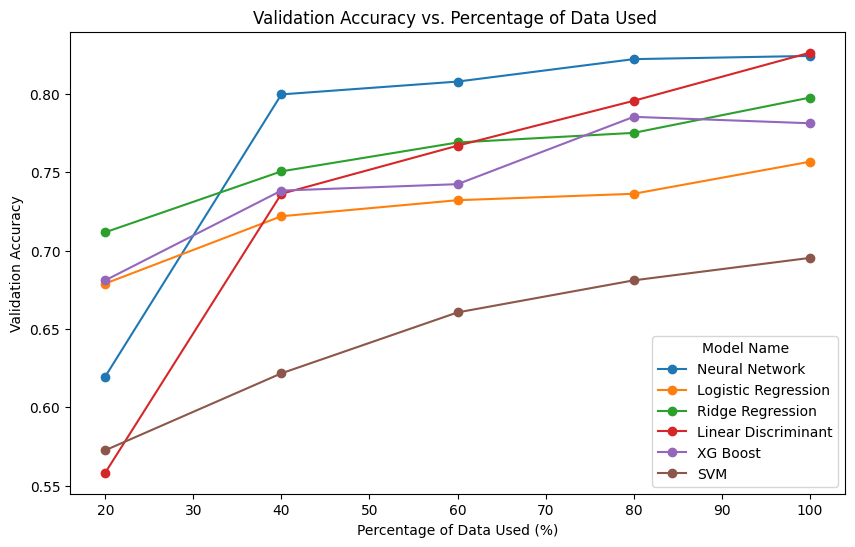

In [12]:
# 2.1.1 Using pretrained emoji2vec embeddings


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

def get_emoji_embedding(emoji):
    try:
        return e2v[emoji]
    except KeyError:
        return np.zeros(300)

def get_aggregated_embedding(emoji_sequence):
    embeddings = [get_emoji_embedding(emoji) for emoji in emoji_sequence]
    return np.array(embeddings)

# Load the datasets
train_df = pd.read_csv(train_emoticon_path)
validation_df = pd.read_csv(valid_emoticon_path)
test_df = pd.read_csv(test_emoticon_path)

train_sequences = train_df['input_emoticon'].values
validation_sequences = validation_df['input_emoticon'].values
train_labels = train_df['label'].values
validation_labels = validation_df['label'].values

# Validation data feature extraction
validation_embeddings = np.array([get_aggregated_embedding(seq) for seq in validation_sequences])
print(validation_embeddings.shape)

# Models for training
models = {
    "Logistic Regression": LogisticRegression(solver='saga', max_iter=1000),
    "Ridge Regression": RidgeClassifier(),
#     "SGD": SGDClassifier(),
#     "Random Forest": RandomForestClassifier(),
#     "MLP": MLPClassifier(),
    "Linear Discriminant": LinearDiscriminantAnalysis(),
    "XG Boost": XGBClassifier(),
#     "Naive Bayes": GaussianNB(),
    "SVM": SVC(C=1.0, gamma='scale'),
#     "LwP": NearestCentroid(metric="manhattan"),
}


def create_neural_net():
    model = Sequential()
    model.add(tf.keras.layers.Input(shape=(13, 300)))
    model.add(GRU(10, return_sequences=True))
    model.add(GRU(5, return_sequences=True))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.3))
    model.add(Dense(16))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])
    return model


percentages = np.linspace(0.2, 1.0, 5)
results = []


# Neural Net
for percent in percentages:
    n_samples = int(len(train_sequences) * percent)
    X_subset_sequences = train_sequences[:n_samples]
    y_subset = train_labels[:n_samples]
    print(f"\nTraining with {percent * 100:.1f}% of the data ({n_samples} samples)")

    train_embeddings=[]
    train_embeddings = np.array([get_aggregated_embedding(seq) for seq in X_subset_sequences])
    print(train_embeddings.shape)

    neural_net = create_neural_net()
    neural_net.fit(train_embeddings, y_subset, validation_data=(validation_embeddings, validation_labels), epochs=50, batch_size=8, verbose=0)

    validation_loss, validation_accuracy = neural_net.evaluate(validation_embeddings, validation_labels, verbose=0)
    print(f"Validation accuracy for Neural Network: {validation_accuracy}")
    results.append([percent * 100, "Neural Network", validation_accuracy])


validation_embeddings = validation_embeddings.reshape(validation_embeddings.shape[0], -1)

for percent in percentages:
    n_samples = int(len(train_sequences) * percent)

    X_subset_sequences = train_sequences[:n_samples]
    y_subset = train_labels[:n_samples]

    print(f"\nTraining with {percent * 100:.1f}% of the data ({n_samples} samples)")


    train_embeddings=[]
    train_embeddings = np.array([get_aggregated_embedding(seq) for seq in X_subset_sequences])
    train_embeddings = train_embeddings.reshape(train_embeddings.shape[0], -1)
    print(train_embeddings.shape)

    for model_name, model in models.items():
        model.fit(train_embeddings, y_subset)
        y_pred_valid = model.predict(validation_embeddings)
        validation_accuracy = accuracy_score(validation_labels, y_pred_valid)
        print(f"Validation accuracy for {model_name}: {validation_accuracy}")
        results.append([percent * 100, model_name, validation_accuracy])



df = pd.DataFrame(results, columns=['percent', 'model_name', 'validation_accuracy'])
plt.figure(figsize=(10, 6))
for model_name in df['model_name'].unique():
    model_df = df[df['model_name'] == model_name]
    plt.plot(model_df['percent'], model_df['validation_accuracy'], marker='o', label=model_name)
plt.title('Validation Accuracy vs. Percentage of Data Used ')
plt.xlabel('Percentage of Data Used (%)')

plt.ylabel('Validation Accuracy')
plt.legend(title='Model Name')
plt.show()


No of unique emojis 214

Training with 20.0% of the data (1416 samples)
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8630 - loss: 1.0993
LSTM Validation Accuracy: 84.87%
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8755 - loss: 0.8137
GRU Validation Accuracy: 86.71%

Training with 40.0% of the data (2832 samples)
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9102 - loss: 0.6454
LSTM Validation Accuracy: 89.16%
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9173 - loss: 0.4050
GRU Validation Accuracy: 90.39%

Training with 60.0% of the data (4248 samples)
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9273 - loss: 0.6306 
LSTM Validation Accuracy: 91.41%
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9352 - loss: 0.2331
GRU Validation Accuracy: 93.05%

Training with 80.0% of the data (5664 samples)
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9122 - loss: 0.6939
LSTM Validation Accuracy: 90.18%
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 10)             │         8,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 4)              │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,309 (114.49 KB)

 Trainable params: 9,769 (38.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,540 (76.33 KB)

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_24 (GRU)                    │ (None, 13, 12)         │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_25 (GRU)                    │ (None, 13, 14)         │         1,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_12     │ (None, 14)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 30)             │           450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 4)              │           124 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,891 (116.77 KB)

 Trainable params: 9,963 (38.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,928 (77.85 KB)


Training with 20.0% of the data (1416 samples)
Validation accuracy for Logistic Regression: 76.07%
Validation accuracy for Ridge Regression: 75.46%
Validation accuracy for Linear Discriminant: 59.10%
Validation accuracy for SVM: 74.85%
Validation accuracy for SGD: 73.21%
Validation accuracy for Naive Bayes: 75.87%

Training with 40.0% of the data (2832 samples)
Validation accuracy for Logistic Regression: 82.21%
Validation accuracy for Ridge Regression: 82.21%
Validation accuracy for Linear Discriminant: 75.87%
Validation accuracy for SVM: 81.80%
Validation accuracy for SGD: 81.80%
Validation accuracy for Naive Bayes: 81.80%

Training with 60.0% of the data (4248 samples)
Validation accuracy for Logistic Regression: 85.28%
Validation accuracy for Ridge Regression: 85.48%
Validation accuracy for Linear Discriminant: 82.82%
Validation accuracy for SVM: 85.28%
Validation accuracy for SGD: 83.23%
Validation accuracy for Naive Bayes: 83.03%

Training with 80.0% of the data (5664 samples)
V

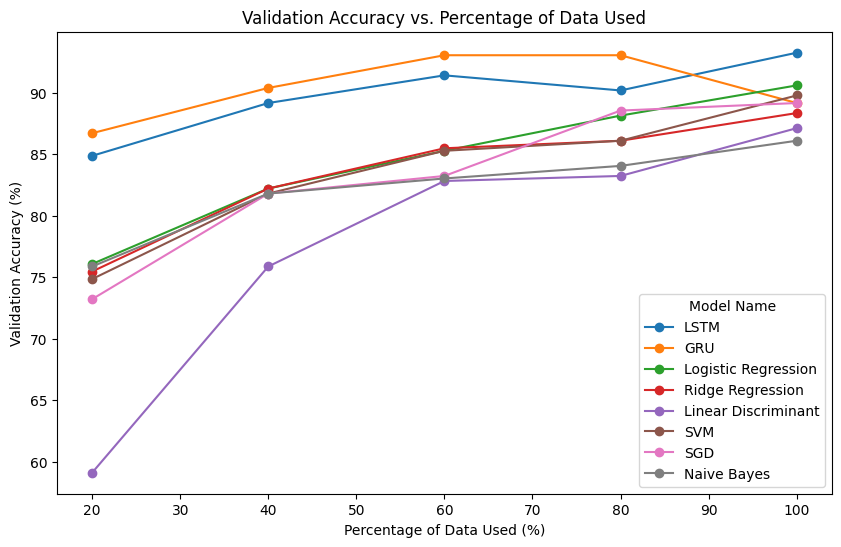

In [14]:
# 2.1.2 One Hot


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout ,Bidirectional
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam


def split_emojis(emoji_string):
    return list(emoji_string)



train_df = pd.read_csv(train_emoticon_path)
val_df = pd.read_csv(valid_emoticon_path)
test_df = pd.read_csv(test_emoticon_path)


train_df['input_emoticon'] = train_df['input_emoticon'].apply(split_emojis)
val_df['input_emoticon'] = val_df['input_emoticon'].apply(split_emojis)


unique_emojis = set()

for row in train_df['input_emoticon']:
    unique_emojis.update(row)

for row in val_df['input_emoticon']:
    unique_emojis.update(row)

unique_emojis = sorted(list(unique_emojis))  # Sort for consistency
print("No of unique emojis",len(unique_emojis))

# Create a dictionary to map each unique emoji to an index for one-hot encoding
emoji_to_index = {emoji: idx for idx, emoji in enumerate(unique_emojis)}

def one_hot_encode_row(emoji_row, unique_emojis, emoji_to_index):
    # Create a matrix for 13 emojis (each row corresponding to an emoji, columns to unique emojis)
    one_hot_matrix = np.zeros((13, len(unique_emojis)))

    for i, emoji in enumerate(emoji_row):
        emoji_idx = emoji_to_index[emoji]
        one_hot_matrix[i, emoji_idx] = 1

    return one_hot_matrix


X_train = np.array([one_hot_encode_row(row, unique_emojis, emoji_to_index) for row in train_df['input_emoticon']])
X_val = np.array([one_hot_encode_row(row, unique_emojis, emoji_to_index) for row in val_df['input_emoticon']])

y_train = train_df['label'].values
y_val = val_df['label'].values

time_steps = X_train.shape[1]
features = X_train.shape[2]


# Define percentages of data to use for training
percentages = np.linspace(0.2, 1.0, 5)
results = []

def create_gru_model():
    model = Sequential()
    model.add(tf.keras.layers.Input(shape=(time_steps,features)))
    model.add(GRU(12, return_sequences=True))
    model.add(GRU(14, return_sequences=True))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.1))
    model.add(Dense(30))
    model.add(Dense(4))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_lstm_model():
    model = Sequential()
    model.add(tf.keras.layers.Input(shape=(time_steps,features)))
    model.add(Bidirectional(LSTM(5, return_sequences=False)))
#     model.add(LSTM(14, return_sequences=True))
#     model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.1))
    model.add(Dense(64))
    model.add(Dense(4))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



for percent in percentages:
    n_samples = int(len(X_train) * percent)
    X_subset = X_train[:n_samples]
    y_subset = y_train[:n_samples]
    print(f"\nTraining with {percent * 100:.1f}% of the data ({n_samples} samples)")
    lstm_model = create_lstm_model()
#     lstm_model.summary()

    gru_model = create_gru_model()
#     gru_model.summary()

    lstm_model.fit(X_subset, y_subset, epochs=30, batch_size=4, validation_data=(X_val, y_val),verbose=0)
    lstm_val_loss, lstm_val_acc = lstm_model.evaluate(X_val, y_val)
    print(f"LSTM Validation Accuracy: {lstm_val_acc * 100:.2f}%")
    results.append([percent * 100, "LSTM", lstm_val_acc * 100])

    gru_model.fit(X_subset, y_subset, epochs=30, batch_size=4, validation_data=(X_val, y_val),verbose=0)
    gru_val_loss, gru_val_acc = gru_model.evaluate(X_val, y_val)
    print(f"GRU Validation Accuracy: {gru_val_acc * 100:.2f}%")
    results.append([percent * 100, "GRU", gru_val_acc * 100])



models = {
    "Logistic Regression": LogisticRegression(max_iter=1000,C=10, class_weight= 'balanced', penalty= 'l2', solver= 'liblinear'),
    "Ridge Regression": RidgeClassifier(alpha=1, class_weight= None),
    "Linear Discriminant": LinearDiscriminantAnalysis(priors= None, solver='svd'),
#     "XG Boost": XGBClassifier(eval_metric='logloss'),
    "SVM": SVC(C=1, degree= 3, gamma= 'scale', kernel= 'linear'),
#     "KNN": KNeighborsClassifier(),
#     "Random Forest": RandomForestClassifier(),
    "SGD":SGDClassifier(alpha= 0.0001, learning_rate= 'optimal', loss= 'hinge', penalty='l2'),
    "Naive Bayes": GaussianNB(priors= None, var_smoothing= 0.1),
}




for percent in percentages:
    n_samples = int(len(X_train) * percent)
    X_subset = X_train[:n_samples].reshape(n_samples, -1)
    y_subset = y_train[:n_samples]
    print(f"\nTraining with {percent * 100:.1f}% of the data ({n_samples} samples)")

    for model_name, model in models.items():
        model.fit(X_subset, y_subset)
        y_pred = model.predict(X_val.reshape(X_val.shape[0], -1))
        validation_accuracy = accuracy_score(y_val, y_pred)
        print(f"Validation accuracy for {model_name}: {validation_accuracy * 100:.2f}%")
        results.append([percent * 100, model_name, validation_accuracy * 100])




# Create a DataFrame to store the results
df = pd.DataFrame(results, columns=['percent', 'model_name', 'validation_accuracy'])

# Plot the validation accuracy against the percentage of data used for each model
plt.figure(figsize=(10, 6))

for model_name in df['model_name'].unique():
    model_df = df[df['model_name'] == model_name]
    plt.plot(model_df['percent'], model_df['validation_accuracy'], marker='o', label=model_name)

plt.title('Validation Accuracy vs. Percentage of Data Used')
plt.xlabel('Percentage of Data Used (%)')
plt.ylabel('Validation Accuracy (%)')
plt.legend(title='Model Name')
plt.show()

In [ ]:
# Hyperparameter Tuning for OneHot

# Function to split emoji strings into individual emojis
def split_emojis(emoji_string):
    return list(emoji_string)

# Load the training and validation datasets

train_df = pd.read_csv(train_emoticon_path)
val_df = pd.read_csv(valid_emoticon_path)
test_df = pd.read_csv(test_emoticon_path)


# Step 1: Split the emojis in the 'input_emoticon' column
train_df['input_emoticon'] = train_df['input_emoticon'].apply(split_emojis)
val_df['input_emoticon'] = val_df['input_emoticon'].apply(split_emojis)

# Step 2: Find all unique emojis in both training and validation datasets
unique_emojis = set()

for row in train_df['input_emoticon']:
    unique_emojis.update(row)

for row in val_df['input_emoticon']:
    unique_emojis.update(row)

unique_emojis = sorted(list(unique_emojis))  # Sort for consistency

# Create a dictionary to map each unique emoji to an index for one-hot encoding
emoji_to_index = {emoji: idx for idx, emoji in enumerate(unique_emojis)}

# Step 3: Function to convert a row of 13 emojis into an unflattened one-hot matrix (13xN)
def one_hot_encode_row(emoji_row, unique_emojis, emoji_to_index):
    # Create a matrix for 13 emojis (each row corresponding to an emoji, columns to unique emojis)
    one_hot_matrix = np.zeros((13, len(unique_emojis)))

    # Fill the matrix with one-hot encoding
    for i, emoji in enumerate(emoji_row):
        emoji_idx = emoji_to_index[emoji]
        one_hot_matrix[i, emoji_idx] = 1

    return one_hot_matrix

# Step 4: Apply one-hot encoding to all rows in training and validation data (as 13xN matrices)
X_train = np.array([one_hot_encode_row(row, unique_emojis, emoji_to_index) for row in train_df['input_emoticon']])
X_val = np.array([one_hot_encode_row(row, unique_emojis, emoji_to_index) for row in val_df['input_emoticon']])

# Extract labels
y_train = train_df['label'].values
y_val = val_df['label'].values




from sklearn.model_selection import GridSearchCV
def custom_scorer(estimator, X, y):
    y_val_pred = estimator.predict(X_val.reshape(X_val.shape[0], -1))
    val_accuracy = accuracy_score(y_val, y_val_pred)
    return val_accuracy

param_grids = {
    "Logistic Regression": {
    'C': [10, 1.0, 0.1, 0.01],
    'penalty': ['l2'],
    'solver': ['saga','liblinear','lbfgs'],
    "class_weight":[None,'balanced']
    },
    "Ridge Regression": {
        'alpha': [0.01, 0.1, 1, 10,100],
        'class_weight': [None, 'balanced'],
    },
    "Random Forest": {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    "KNN": {
        'n_neighbors' : list(range(5, 30, 2)),
        'weights' : ['uniform','distance'],
        'metric' : ['euclidean','manhattan']
    },
    "Linear Discriminant": {
    'solver': ['svd', 'lsqr'],
    'priors': [None, [0.5, 0.5], [0.3, 0.7]],  # Uniform priors or custom priors
    },
    "XG Boost": {
    "booster":["gbtree","gblinear"],
    'max_depth': [3, 6, 12,18],
    'learning_rate': [0.01, 0.1,0.5],
    'sampling_method':["uniform","gradient_based"],
    "lambda":[0.5,1,5,10],
    "grow_policy":["depthwise","lossguide"],
    },
    "Naive Bayes": {
    'priors': [None, [0.5, 0.5], [0.3, 0.7]],
    'var_smoothing': np.logspace(0, -9, num=10)
    },
    "SVM": {
        'C': [0.01,0.1, 1, 10],
        'kernel': ['linear','poly', 'rbf', 'sigmoid'],
        'degree':[3,5,7],
        'gamma': ['scale', 'auto']
    },
    "SGD":{
    'loss': ['hinge', 'log_loss',],
    'alpha': [0.0001,0.001, 0.01, 0.1, 1],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'penalty': ['l2'],
    },
}


models = {
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "Ridge Regression": RidgeClassifier(),
    "Linear Discriminant": LinearDiscriminantAnalysis(),
#     "Random Forest": RandomForestClassifier(),
#     "XG Boost": XGBClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SGD":SGDClassifier(),

}

percentages = np.linspace(0.2, 1.0, 5)
results = []

# Loop over different percentages of data
for percent in percentages:
    n_samples = int(len(X_train) * percent)
    X_subset = X_train[:n_samples].reshape(n_samples, -1)
    y_subset = y_train[:n_samples]
    print(f"\nTraining with {percent * 100:.1f}% of the data ({n_samples} samples)")

    for model_name, model in models.items():
        param_grid = param_grids[model_name]
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring=custom_scorer,
            refit=False,  # We don't want to refit on the training set, just get the best params
            cv=[(slice(None), slice(None))]  # No real cross-validation, use whole subset
        )

        grid_search.fit(X_subset, y_subset)
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        best_model = model.set_params(**best_params)

        best_model.fit(X_subset, y_subset)


        y_pred = best_model.predict(X_val.reshape(X_val.shape[0], -1))
        validation_accuracy = accuracy_score(y_val, y_pred)

        print(f"Validation accuracy for {model_name}: {validation_accuracy * 100:.2f}% using {best_params}")
        results.append([percent * 100, model_name, validation_accuracy * 100])




df = pd.DataFrame(results, columns=['percent', 'model_name', 'validation_accuracy'])

plt.figure(figsize=(10, 6))

for model_name in df['model_name'].unique():
    model_df = df[df['model_name'] == model_name]
    plt.plot(model_df['percent'], model_df['validation_accuracy'], marker='o', label=model_name)

plt.title('Validation Accuracy vs. Percentage of Data Used (With Hyperparameter Tuning)')
plt.xlabel('Percentage of Data Used (%)')
plt.ylabel('Validation Accuracy')
plt.legend(title='Model Name')
plt.show()


In [ ]:
# 2.1.3 Embedding Layers

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Embedding, Input
import matplotlib.pyplot as plt

# Load the dataset
train_df = pd.read_csv(train_emoticon_path)
val_df = pd.read_csv(valid_emoticon_path)
test_df = pd.read_csv(test_emoticon_path)


# Split emoji strings into individual emojis
def split_emojis(emoji_string):
    return list(emoji_string)

train_df['input_emoticon'] = train_df['input_emoticon'].apply(split_emojis)
val_df['input_emoticon'] = val_df['input_emoticon'].apply(split_emojis)

# Extract labels
y_train = train_df['label'].values
y_val = val_df['label'].values

# Tokenize emojis
tokenizer = Tokenizer(char_level=True, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['input_emoticon'])  # Fit tokenizer on training data
word_index = tokenizer.word_index

# Convert emojis to sequences of integers
X_train = tokenizer.texts_to_sequences(train_df['input_emoticon'])
X_val = tokenizer.texts_to_sequences(val_df['input_emoticon'])

# Padding sequences to ensure uniform input length (13 emojis per input)
X_train = pad_sequences(X_train, maxlen=13, padding='post')
X_val = pad_sequences(X_val, maxlen=13, padding='post')

vocab_size = len(word_index) + 1  # Adding 1 because of padding and OOV tokens

# GRU model definition
def create_gru_model():
    model = Sequential()
    model.add(Input(shape=(13,)))
    model.add(Embedding(input_dim=vocab_size, output_dim=32))
    model.add(GRU(12, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# LSTM model definition
def create_lstm_model():
    model = Sequential()
    model.add(Input(shape=(13,)))
    model.add(Embedding(input_dim=vocab_size, output_dim=32))
    model.add(LSTM(12, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train on different percentages of data and store results
percentages = np.linspace(0.2, 1.0, 5)  # Training with 20%, 40%, ..., 100% of the data
results = []

for percent in percentages:
    n_samples = int(len(X_train) * percent)
    X_subset = X_train[:n_samples]
    y_subset = y_train[:n_samples]

    print(f"\nTraining with {percent * 100:.1f}% of the data ({n_samples} samples)")

    # Train GRU model
    model = create_gru_model()
    model.fit(X_subset, y_subset, epochs=50, batch_size=16, validation_data=(X_val, y_val), verbose=0)
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f'Validation Accuracy for GRU: {val_accuracy:.4f}')
    results.append((percent * 100, 'GRU', val_accuracy))

    # Train LSTM model
    model = create_lstm_model()
    model.fit(X_subset, y_subset, epochs=50, batch_size=16, validation_data=(X_val, y_val), verbose=0)
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f'Validation Accuracy for LSTM: {val_accuracy:.4f}')
    results.append((percent * 100, 'LSTM', val_accuracy))

# Convert results to a DataFrame for easier analysis
results_df = pd.DataFrame(results, columns=['Percentage of Data', 'Model', 'Validation Accuracy'])

# Plot the results
plt.figure(figsize=(10, 6))
for model_name in results_df['Model'].unique():
    model_data = results_df[results_df['Model'] == model_name]
    plt.plot(model_data['Percentage of Data'], model_data['Validation Accuracy'], marker='o', label=model_name)

plt.title('Validation Accuracy vs Percentage of Training Data')
plt.xlabel('Percentage of Data Used (%)')
plt.ylabel('Validation Accuracy')
plt.legend(title='Model')
plt.grid(True)
plt.show()